In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import Constraint


In [2]:
%matplotlib inline

import logging

logging.basicConfig(level="INFO")

In [3]:
# ratio between max heat output and max electric output
nom_r = 1.0

# backpressure limit
c_m = 0.75

# marginal loss for each additional generation of heat
c_v = 0.15

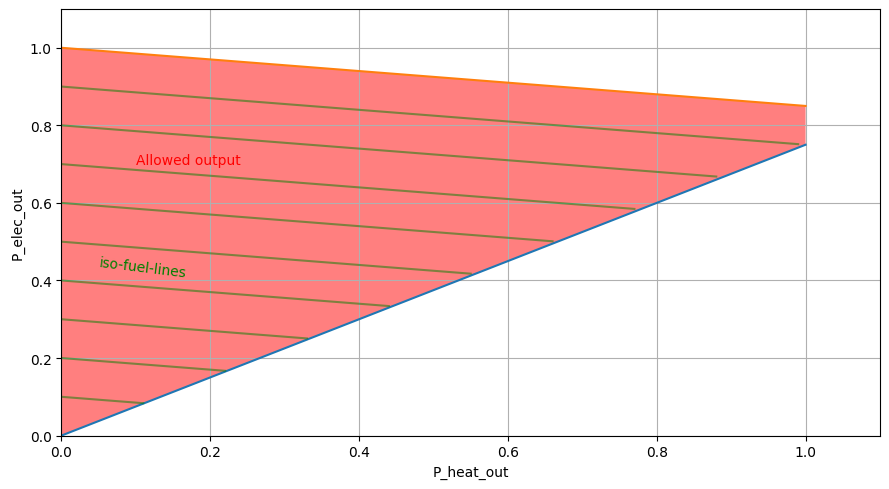

In [4]:
fig, ax = plt.subplots(figsize=(9, 5))

t = 0.01
ph = np.arange(0, 1.0001, t)

ax.plot(ph, c_m * ph)
ax.set_xlabel("P_heat_out")
ax.set_ylabel("P_elec_out")
ax.grid(True)

ax.set_xlim([0, 1.1])
ax.set_ylim([0, 1.1])
ax.text(0.1, 0.7, "Allowed output", color="r")
ax.plot(ph, 1 - c_v * ph)

for i in range(1, 10):
    k = 0.1 * i
    x = np.arange(0, k / (c_m + c_v), t)
    ax.plot(x, k - c_v * x, color="g", alpha=0.5)

ax.text(0.05, 0.41, "iso-fuel-lines", color="g", rotation=-7)
ax.fill_between(ph, c_m * ph, 1 - c_v * ph, facecolor="r", alpha=0.5)

fig.tight_layout()

In [5]:
network = pypsa.Network()
network.set_snapshots(pd.date_range("2016-01-01 00:00", "2016-01-01 03:00", freq="H"))

network.add("Bus", "0", carrier="AC")
network.add("Bus", "0 gas", carrier="gas")

network.add("Carrier", "wind")
network.add("Carrier", "gas", co2_emissions=0.2)

network.add("GlobalConstraint", "co2_limit", sense="<=", constant=0.0)

network.add(
    "Generator",
    "wind turbine",
    bus="0",
    carrier="wind",
    p_nom_extendable=True,
    p_max_pu=[0.0, 0.2, 0.7, 0.4],
    capital_cost=1000,
)

network.add("Load", "load", bus="0", p_set=5.0)

network.add(
    "Link",
    "P2G",
    bus0="0",
    bus1="0 gas",
    efficiency=0.6,
    capital_cost=1000,
    p_nom_extendable=True,
)

network.add(
    "Link",
    "generator",
    bus0="0 gas",
    bus1="0",
    efficiency=0.468,
    capital_cost=400,
    p_nom_extendable=True,
)

network.add("Store", "gas depot", bus="0 gas", e_cyclic=True, e_nom_extendable=True)

In [6]:
network.add("Bus", "0 heat", carrier="heat")

network.add("Carrier", "heat")

network.add("Load", "heat load", bus="0 heat", p_set=10.0)

network.add(
    "Link",
    "boiler",
    bus0="0 gas",
    bus1="0 heat",
    efficiency=0.9,
    capital_cost=300,
    p_nom_extendable=True,
)

network.add("Store", "water tank", bus="0 heat", e_cyclic=True, e_nom_extendable=True)


In [7]:
# Guarantees ISO fuel lines, i.e. fuel consumption p_b0 + p_g0 = constant along p_g1 + c_v p_b1 = constant
network.links.at["boiler", "efficiency"] = (
    network.links.at["generator", "efficiency"] / c_v
)

model = network.optimize.create_model()

link_p = model.variables["Link-p"]
link_p_nom = model.variables["Link-p_nom"]

# Guarantees heat output and electric output nominal powers are proportional
model.add_constraints(
    network.links.at["generator", "efficiency"] * nom_r * link_p_nom["generator"]
    - network.links.at["boiler", "efficiency"] * link_p_nom["boiler"]
    == 0,
    name="heat-power output proportionality",
)

# Guarantees c_m p_b1  \leq p_g1
model.add_constraints(
    c_m * network.links.at["boiler", "efficiency"] * link_p.sel(Link="boiler")
    - network.links.at["generator", "efficiency"] * link_p.sel(Link="generator")
    <= 0,
    name="backpressure",
)

# Guarantees p_g1 +c_v p_b1 \leq p_g1_nom
model.add_constraints(
    link_p.sel(Link="boiler")
    + link_p.sel(Link="generator")
    - link_p_nom.sel({"Link-ext": "generator"})
    <= 0,
    name="top_iso_fuel_line",
)

network.optimize.solve_model()

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

<__array_function__ internals>:200: RuntimeWarning:

invalid value encountered in cast

INFO:linopy.model: Solve linear problem using Glpk solver
INFO:linopy.io: Writing time: 0.3s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 38 primals, 83 duals
Objective: 1.62e+05
Solver model: not available
Solver message: optimal



GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --lp C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-0j3zqwxq.lp --output
 C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-c9u4aquq.sol
Reading problem data from 'C:\Users\2F06~1\AppData\Local\Temp\linopy-problem-0j3zqwxq.lp'...
83 rows, 38 columns, 159 non-zeros
555 lines were read
GLPK Simplex Optimizer, v4.65
83 rows, 38 columns, 159 non-zeros
Preprocessing...
52 rows, 37 columns, 127 non-zeros
Scaling...
 A: min|aij| =  2.000e-01  max|aij| =  3.120e+00  ratio =  1.560e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 50
      0: obj =   0.000000000e+00 inf =   1.377e+02 (11)
     22: obj =   1.703538022e+05 inf =   0.000e+00 (0)
*    25: obj =   1.622539996e+05 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (104191 bytes)
Writing basic solution to 'C:\Users\2F06~1\AppData\Local\Temp\linopy-solve-c9u4aquq.sol'...


('ok', 'optimal')

In [8]:
network.iplot()

{'data': [{'x': 0        -1.0
   0 gas     1.0
   0 heat    0.0
   Name: x, dtype: float64,
   'y': 0        -0.333333
   0 gas    -0.333333
   0 heat    0.666667
   Name: y, dtype: float64,
   'text': Index(['Bus 0', 'Bus 0 gas', 'Bus 0 heat'], dtype='object', name='Bus'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'opacity': 1,
   'marker': {'color': 'cadetblue', 'size': 10}},
  {'x': Link
   P2G          0.0
   generator    0.0
   boiler       0.5
   dtype: float64,
   'y': Link
   P2G         -0.333333
   generator   -0.333333
   boiler       0.166667
   dtype: float64,
   'text': Index(['Link P2G', 'Link generator', 'Link boiler'], dtype='object', name='Link'),
   'type': 'scatter',
   'mode': 'markers',
   'hoverinfo': 'text',
   'marker': {'opacity': 0.0}}],
 'layout': {'title': '',
  'hovermode': 'closest',
  'showlegend': False,
  'shapes': [{'type': 'line',
    'opacity': 0.8,
    'x0': -1.0,
    'y0': -0.3333333333333333,
    'x1': 1.0,
    'y1': 

In [9]:
network.objective

162253.9996

In [10]:
network.loads_t.p

Load,load,heat load
snapshot,,
2016-01-01 00:00:00,5.0,10.0
2016-01-01 01:00:00,5.0,10.0
2016-01-01 02:00:00,5.0,10.0
2016-01-01 03:00:00,5.0,10.0


In [11]:
network.links.p_nom_opt

Link
P2G          58.6489
generator    28.4900
boiler        4.2735
Name: p_nom_opt, dtype: float64

In [12]:
# CHP is dimensioned by the heat demand met in three hours when no wind
4 * 10.0 / 3 / network.links.at["boiler", "efficiency"]

4.273504273504273

In [13]:
# elec is set by the heat demand
28.490028 * 0.15

4.2735042

In [14]:
network.links_t.p0

Link,P2G,generator,boiler
snapshot,,,
2016-01-01 00:00:00,5.0000,21.3675,4.2735
2016-01-01 01:00:00,23.1854,21.3675,4.2735
2016-01-01 02:00:00,58.6489,0.0000,0.0000
2016-01-01 03:00:00,41.3708,21.3675,4.2735


In [15]:
network.links_t.p1

Link,P2G,generator,boiler
snapshot,,,
2016-01-01 00:00:00,-3.00000,-9.99999,-13.33332
2016-01-01 01:00:00,-13.91124,-9.99999,-13.33332
2016-01-01 02:00:00,-35.18934,-0.00000,-0.00000
2016-01-01 03:00:00,-24.82248,-9.99999,-13.33332


In [16]:
pd.DataFrame({attr: network.stores_t[attr]["gas depot"] for attr in ["p", "e"]})

,p,e
snapshot,,
2016-01-01 00:00:00,22.64100,11.7298
2016-01-01 01:00:00,11.72980,0.0000
2016-01-01 02:00:00,-35.18930,35.1893
2016-01-01 03:00:00,0.81854,34.3708


In [17]:
pd.DataFrame({attr: network.stores_t[attr]["water tank"] for attr in ["p", "e"]})

,p,e
snapshot,,
2016-01-01 00:00:00,-3.33333,6.66667
2016-01-01 01:00:00,-3.33333,10.00000
2016-01-01 02:00:00,10.00000,0.00000
2016-01-01 03:00:00,-3.33333,3.33333


In [18]:
pd.DataFrame({attr: network.links_t[attr]["boiler"] for attr in ["p0", "p1"]})

,p0,p1
snapshot,,
2016-01-01 00:00:00,4.2735,-13.33332
2016-01-01 01:00:00,4.2735,-13.33332
2016-01-01 02:00:00,0.0000,-0.00000
2016-01-01 03:00:00,4.2735,-13.33332


In [19]:
network.stores.loc["gas depot"]

attribute
bus                       0 gas
type                           
carrier                     gas
e_nom                       0.0
e_nom_extendable           True
e_nom_min                   0.0
e_nom_max                   inf
e_min_pu                    0.0
e_max_pu                    1.0
e_initial                   0.0
e_initial_per_period      False
e_cyclic                   True
e_cyclic_per_period        True
p_set                       0.0
q_set                       0.0
sign                        1.0
marginal_cost               0.0
capital_cost                0.0
standing_loss               0.0
build_year                    0
lifetime                    inf
e_nom_opt               35.1893
Name: gas depot, dtype: object

In [20]:
network.generators.loc["wind turbine"]

attribute
bus                          0
control                     PQ
type                          
p_nom                      0.0
p_nom_extendable          True
p_nom_min                  0.0
p_nom_max                  inf
p_min_pu                   0.0
p_max_pu                   1.0
p_set                      0.0
q_set                      0.0
sign                       1.0
carrier                   wind
marginal_cost              0.0
build_year                   0
lifetime                   inf
capital_cost            1000.0
efficiency                 1.0
committable              False
start_up_cost              0.0
shut_down_cost             0.0
min_up_time                  0
min_down_time                0
up_time_before               1
down_time_before             0
ramp_limit_up              NaN
ramp_limit_down            NaN
ramp_limit_start_up        1.0
ramp_limit_shut_down       1.0
p_nom_opt               90.927
Name: wind turbine, dtype: object

In [21]:
network.links.p_nom_opt

Link
P2G          58.6489
generator    28.4900
boiler        4.2735
Name: p_nom_opt, dtype: float64

In [22]:
eta_elec = network.links.at["generator", "efficiency"]

r = 1 / c_m

# P_h = r*P_e
(1 + r) / ((1 / eta_elec) * (1 + c_v * r))

0.9099999999999999

In [23]:
network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
0,1.0,,0.0,0.0,AC,,1.0,0.0,inf,PQ,
0 gas,1.0,,0.0,0.0,gas,,1.0,0.0,inf,PQ,
0 heat,1.0,,0.0,0.0,heat,,1.0,0.0,inf,PQ,


In [24]:
network.carriers

attribute,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
wind,0.0,,,inf,0.0
gas,0.2,,,inf,0.0
heat,0.0,,,inf,0.0


In [25]:
network.global_constraints

attribute,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,0.0


In [26]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
wind turbine,0,PQ,,0.0,True,0.0,inf,0.0,1.0,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,90.927


In [27]:
network.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
P2G,0,0 gas,,AC,0.600,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,58.6489
generator,0 gas,0,,gas,0.468,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,28.4900
boiler,0 gas,0 heat,,gas,3.120,0,inf,0.0,True,0.0,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,4.2735


In [28]:
network.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,...,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
gas depot,0 gas,,gas,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf,35.1893
water tank,0 heat,,heat,0.0,True,0.0,inf,0.0,1.0,0.0,...,True,0.0,0.0,1.0,0.0,0.0,0.0,0,inf,10.0000


In [29]:
network.loads

attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
load,0,,,5.0,0.0,-1.0
heat load,0 heat,,,10.0,0.0,-1.0


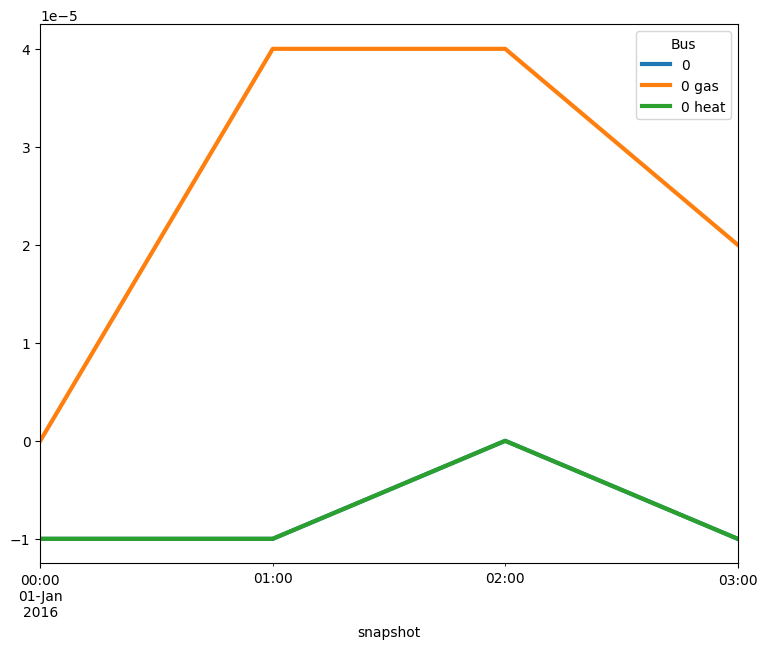

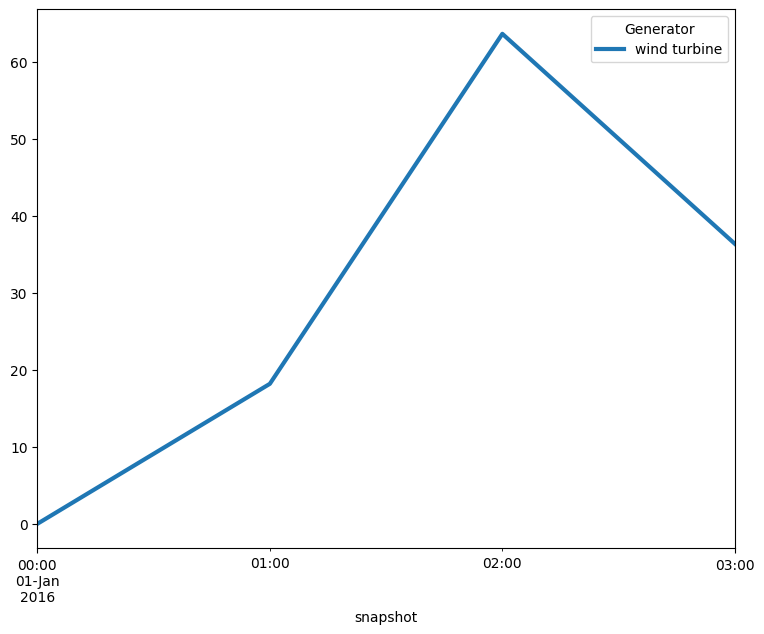

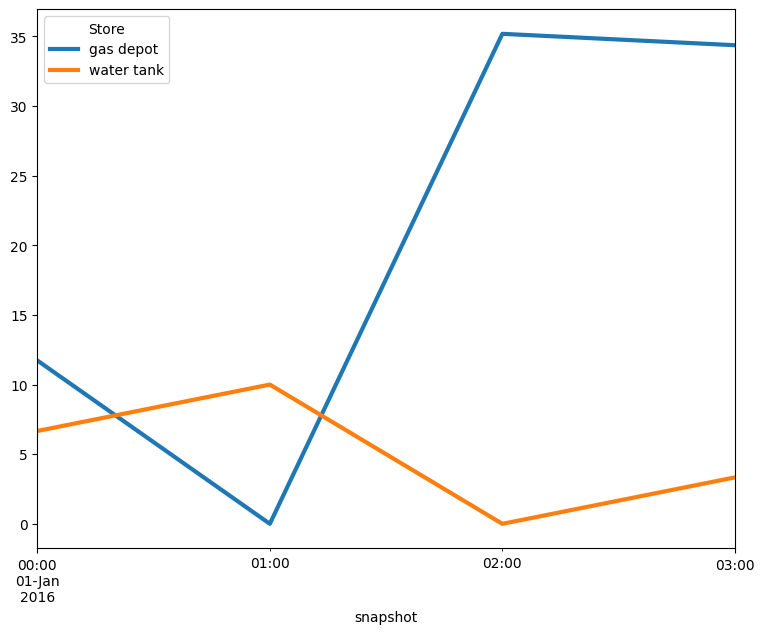

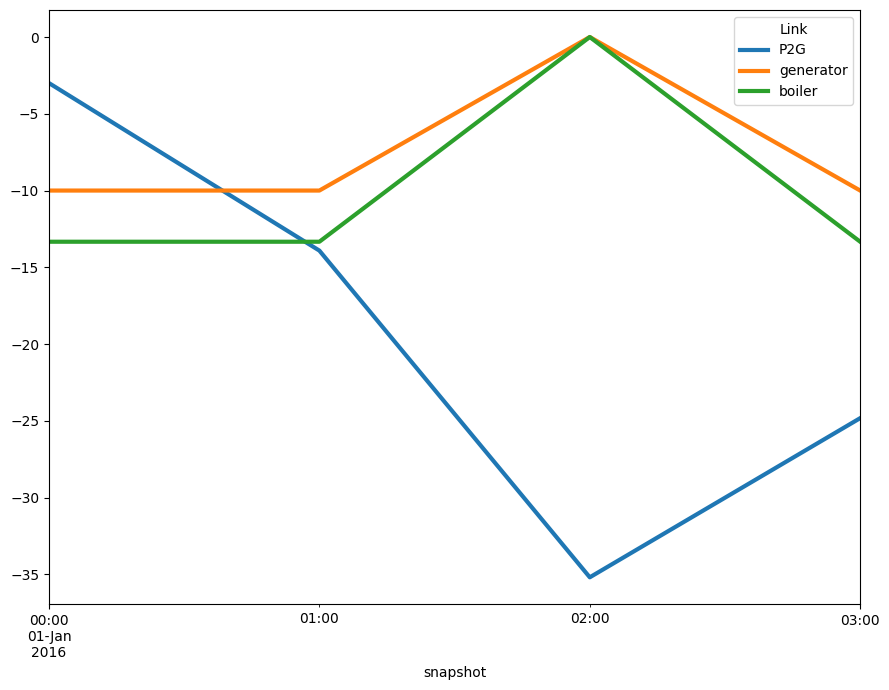

In [30]:
network.buses_t.p.plot(figsize=(9, 7), lw=3)
network.generators_t.p.plot(figsize=(9, 7), lw=3)
network.stores_t.e.plot(figsize=(9, 7), lw=3)
network.links_t.p1.plot(figsize=(9, 7), lw=3)
plt.tight_layout()